<a href="https://colab.research.google.com/github/nattiya/Thai_TTS_tacotron2/blob/main/Thai_TTS_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting the Dataset

In [1]:
import os
import shutil
def download():
    url = "https://github.com/korakot/corpus/releases/download/v1.0/AIFORTHAI-TSync2Corpus.zip"
    print("NECTEC licensed TSync2 under CC-BY-NC-SA")
    print("Start downloading: .. ")
    os.system(f"wget {url}")
    os.system("unzip AIFORTHAI-TSync2Corpus.zip")
    os.system("rm AIFORTHAI-TSync2Corpus.zip")
    shutil.move('/content/TSync2/wav','/content/wav')
    shutil.move('/content/TSync2/wrd_ph','/content/wrd_ph')
    os.system("rm /content/TSync2")
    print("Finished")

In [2]:
download()

NECTEC licensed TSync2 under CC-BY-NC-SA
Start downloading: .. 
Finished


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/TSync2/TSync2.zip

# Trim silence sampling rate = 220505

In [4]:
import matplotlib.pyplot as plt
import os
import librosa
import shutil
import soundfile as sf
from tqdm.auto import tqdm

In [5]:
def trim(directory,filename,sr=22050, threshold=20):
  new_filename = "{}.wav".format(filename[:-4])
  signal, sr = librosa.load(os.path.join(directory,filename), sr=sr)
  trimed, index = librosa.effects.trim(signal, top_db=threshold)
  sf.write(os.path.join(directory, new_filename), trimed, samplerate=sr)
  shutil.move(os.path.join(directory, new_filename) , os.path.join('/content/wav', new_filename))

Trimming the silence (this would take a while)

In [6]:
source = '/content/wav/'
for root, dirnames, filenames in os.walk(source):
    for filename in filenames:
      try:
        trim(source,filename)
      except:
        pass

# Tacotron2

In [7]:
%cd /content/

/content


In [8]:
%tensorflow_version 1.x
import os
from os.path import exists, join, basename, splitext
git_repo_url = 'https://github.com/Prim9000/tacotron2.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install
  !git clone -q --recursive {git_repo_url}
  !cd {project_name}/waveglow && git checkout 9168aea
  !pip install -q librosa unidecode
  
import sys
sys.path.append(join(project_name, 'waveglow/'))
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

TensorFlow 1.x selected.
Previous HEAD position was 5bc2a53 README.md: reporting correct number after finding bug in inference time code
HEAD is now at 9168aea README.md: layout
     |████████████████████████████████| 235 kB 5.0 MB/s 


In [9]:
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

tacotron2_pretrained_model = 'tacotron2_statedict.pt'
if not exists(tacotron2_pretrained_model):
  # download the Tacotron2 pretrained model
  download_from_google_drive('1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA', tacotron2_pretrained_model)
waveglow_pretrained_model = 'waveglow_old.pt'
if not exists(waveglow_pretrained_model):
  # download the Waveglow pretrained model  
  download_from_google_drive('1WsibBTsuRg_SF2Z6L6NFRTT-NjEy1oTx', waveglow_pretrained_model)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0    864      0 --:--:-- --:--:-- --:--:--   862
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  107M    0  107M    0     0  69.4M      0 --:--:--  0:00:01 --:--:--  250M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   2060      0 --:--:-- --:--:-- --:--:--  2050
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  644M    0  644M    0     0   205M      0 --:--:--  0:00:03 --:--:--  264M


In [11]:
import IPython.display as ipd
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from text import text_to_sequence
from denoiser import Denoiser

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none', cmap='viridis')

torch.set_grad_enabled(False)
        
# initialize Tacotron2 with the pretrained model
hparams = create_hparams()
hparams.sampling_rate = 22050
model = Tacotron2(hparams)
model.load_state_dict(torch.load(tacotron2_pretrained_model)['state_dict'])
_ = model.cuda().eval()#.half()

# initialize Waveglow with the pretrained model
# waveglow = torch.load(waveglow_pretrained_model)['model']
# WORKAROUND for: https://github.com/NVIDIA/tacotron2/issues/182
import json
from glow import WaveGlow
waveglow_config = json.load(open('%s/waveglow/config.json' % project_name))['waveglow_config']
waveglow = WaveGlow(**waveglow_config)
waveglow.load_state_dict(torch.load(waveglow_pretrained_model)['model'].state_dict())
_ = waveglow.cuda().eval()#.half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

In [12]:
%cd /content/tacotron2

/content/tacotron2


In [13]:
shutil.move('/content/tacotron2_statedict.pt','/content/tacotron2/tacotron2_statedict.pt')

'/content/tacotron2/tacotron2_statedict.pt'

In [14]:
from scipy.io import wavfile
samplerate, data = wavfile.read('/content/wav/tsync2_noon_0_1228.wav')

# Training

In [15]:
%load_ext tensorboard

In [24]:
%tensorboard --logdir=/content/drive/MyDrive/logdir

In [17]:
!gdown --id 1tukxLX1Ul2O3zpTztX18K6WWfMrPiXJ2

Downloading...
From: https://drive.google.com/uc?id=1tukxLX1Ul2O3zpTztX18K6WWfMrPiXJ2
To: /content/tacotron2/checkpoint_10000
338MB [00:04, 77.4MB/s]


In [ ]:
# Training from the beginning
#!python train.py --output_directory=outdir --log_directory=logdir -c tacotron2_statedict.pt --warm_start

In [ ]:
# Training from scratch (cold start)
#!python train.py --output_directory=outdir --log_directory=logdir

In [25]:
!python train.py --output_directory=/content/drive/MyDrive/tts_outdir/ --log_directory=logdir -c /content/tacotron2/checkpoint_10000 --warm_start

Train loss 10058 0.329241 Grad Norm 1.605212 1.39s/it
Train loss 10059 0.270482 Grad Norm 1.134194 1.95s/it
Train loss 10060 0.294801 Grad Norm 1.199878 1.88s/it
Train loss 10061 0.337668 Grad Norm 2.071187 1.95s/it
Train loss 10062 0.325533 Grad Norm 0.791603 1.47s/it
Train loss 10063 0.371522 Grad Norm 2.116419 1.38s/it
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f328fd07560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.7/

# Synthesizing Speech

In [26]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

In [27]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [28]:
hparams = create_hparams()
hparams.sampling_rate = 22050

### Change your checkpoint

In [29]:
#change your checkpoint path here
checkpoint_path ='/content/drive/MyDrive/tts_outdir/checkpoint_10000' # '/content/tacotron2/outdir/checkpoint_0'
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [30]:
waveglow_path = '/content/waveglow_old.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

In [31]:
!pip install pythainlp

     |████████████████████████████████| 11.0 MB 5.1 MB/s 
     |████████████████████████████████| 743 kB 64.7 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3


## Change your text

In [39]:
#text = 'ยินดีที่ได้รู้จัก นี่คือเสียงจากปัญญาประดิษฐ์'
text = 'ขอต้อนรับสู่ SCG Home ขอเชิญคุณลูกค้าเลือกชมสินค้าของเราอย่างมีความสุขนะคะ'

In [40]:
from pythainlp import word_tokenize
def text_process(text):
    final = text
    final = word_tokenize(final)
    final = " ".join(word for word in final)
    final += " ."
    return final
text = text_process(text)

In [34]:
text

'ยินดี ที่ ได้ รู้จัก   นี่ คือ เสียง จาก ปัญญาประดิษฐ์ .'

In [41]:
text

'ขอ ต้อนรับ สู่   SCG   Home   ขอ เชิญ คุณ ลูกค้า เลือก ชม สินค้า ของ เรา อย่าง มีความสุข นะคะ .'

In [42]:
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

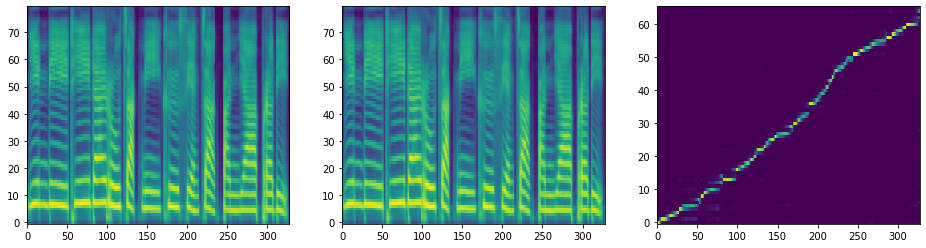

In [36]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
%matplotlib inline
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

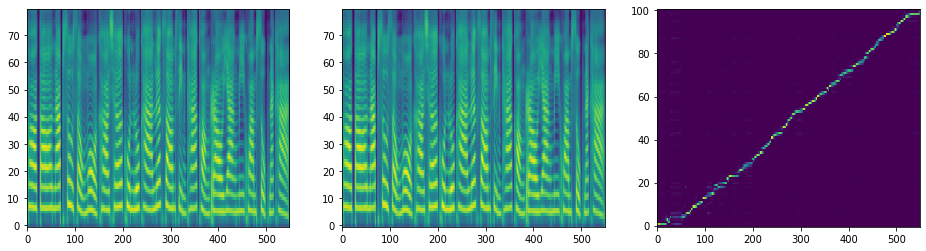

In [43]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
%matplotlib inline
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

## The Synthesized Speech

In [ ]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [37]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [44]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

Add Denoiser

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate)

In [38]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate)

In [45]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate)